In [ ]:
import os
import getpass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from openai import OpenAI

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')





Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ai4i2020.csv')
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


Shape: (10000, 13)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Air temperature [K]      10000 non-null  float64
 1   Process temperature [K]  10000 non-null  float64
 2   Rotational speed [rpm]   10000 non-null  int64  
 3   Torque [Nm]              10000 non-null  float64
 4   Tool wear [min]          10000 non-null  int64  
 5   Machine failure          10000 non-null  int64  
 6   TWF                      10000 non-null  int64  
 7   HDF                      10000 non-null  int64  
 8   PWF                      10000 non-null  int64  
 9   OSF                      10000 non-null  int64  
 10  RNF                      10000 non-null  int64  
 11  Type_L                   10000 non-null  bool   
 12  Type_M                   10000 non-null  bool   
dtypes: bool(2), float64(3), int64(8)
memory usage: 879.

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000



Target value counts:
Machine failure
0    0.9661
1    0.0339
Name: proportion, dtype: float64


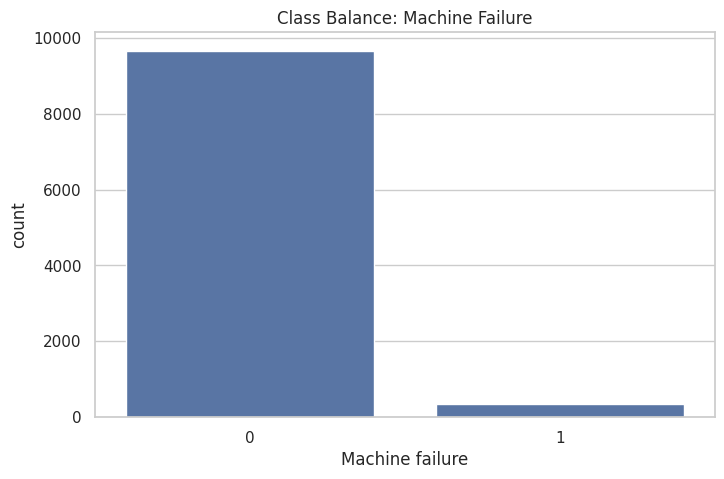

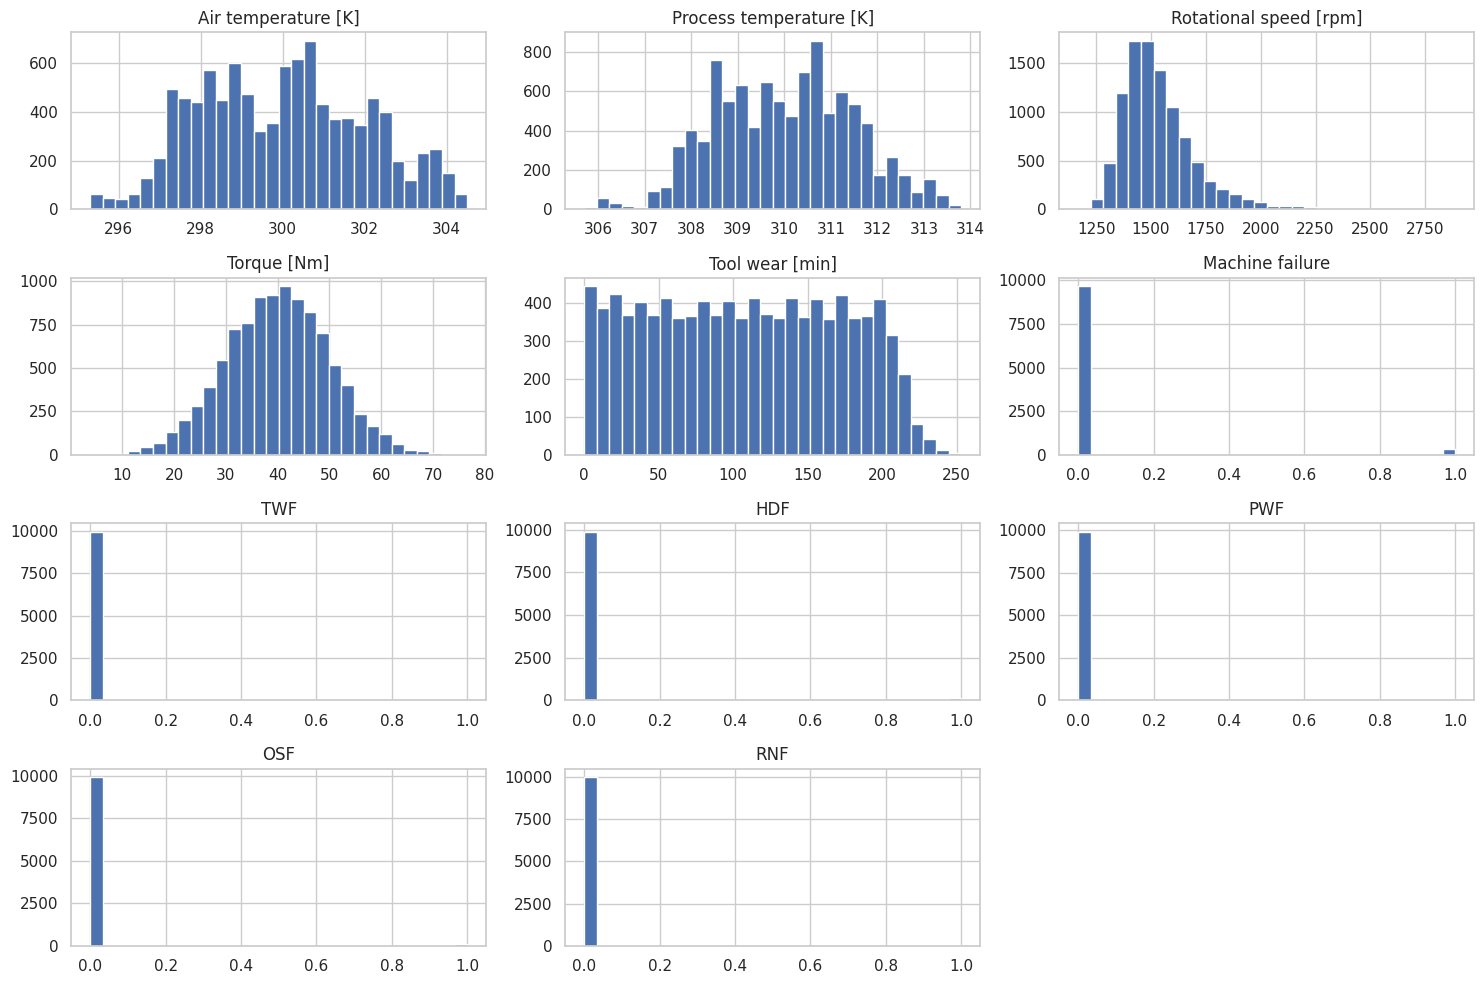

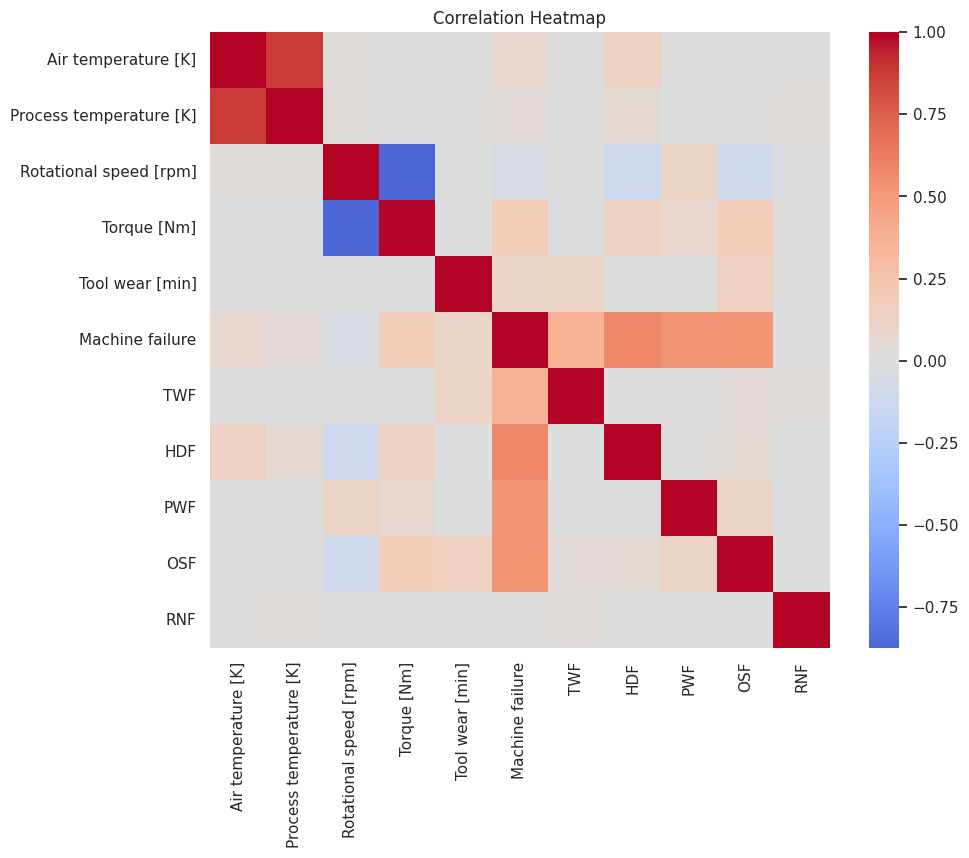

In [ ]:
print("Shape:", df.shape)
print("\nInfo:")
print(df.info())

print("\nDescribe (numeric):")
display(df.describe())

if "Machine failure" in df.columns:
    target_col = "Machine failure"
else:
    target_col = "machine_failure"

print("\nTarget value counts:")
print(df[target_col].value_counts(normalize=True))

sns.countplot(x=df[target_col])
plt.title("Class Balance: Machine Failure")
plt.show()

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c not in ["UDI"]]

df[num_cols].hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

corr = df[num_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Heatmap")
plt.show()


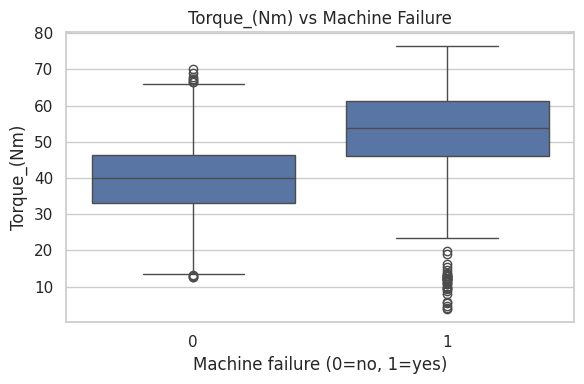

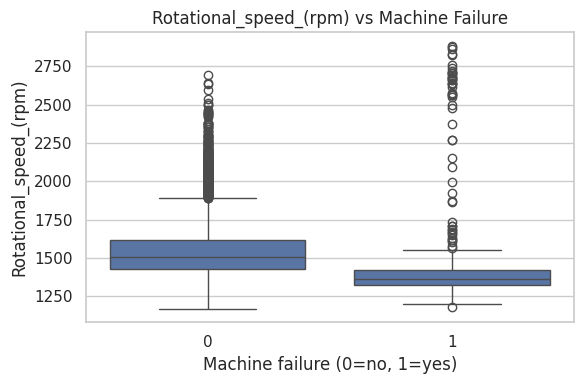

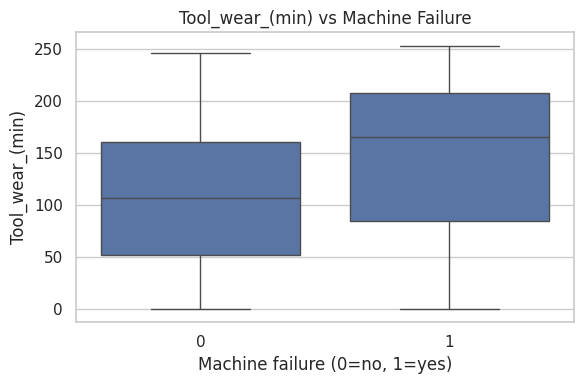

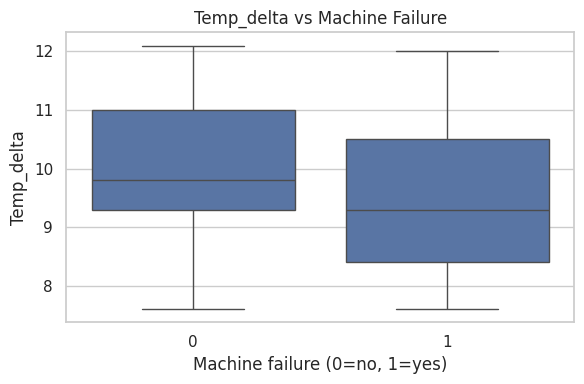

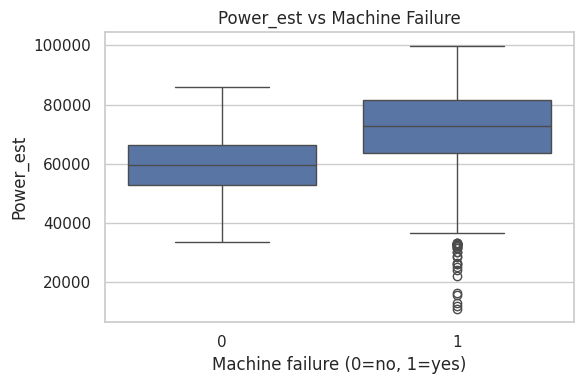

In [ ]:
key_features = [
    "Torque_(Nm)",
    "Rotational_speed_(rpm)",
    "Tool_wear_(min)",
    "Temp_delta",
    "Power_est"
]

for feat in key_features:
    if feat not in X.columns:
        continue
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=y, y=X[feat])
    plt.title(f"{feat} vs Machine Failure")
    plt.xlabel("Machine failure (0=no, 1=yes)")
    plt.ylabel(feat)
    plt.tight_layout()
    plt.show()


In [ ]:
df_fe = df.copy()

for col in ["UDI", "Product ID"]:
    if col in df_fe.columns:
        df_fe.drop(columns=[col], inplace=True)


air_column = "Air temperature [K]"
proc_column = "Process temperature [K]"
torque_column = "Torque [Nm]"
speed_column = "Rotational speed [rpm]"
wear_column = "Tool wear [min]"

if all(c in df_fe.columns for c in [air_column, proc_column, torque_column, speed_column]):
    df_fe["Temp_delta"] = df_fe[proc_column] - df_fe[air_column]
    df_fe["Power_est"] = df_fe[torque_column] * df_fe[speed_column]


if "Type" in df_fe.columns:
    df_fe = pd.get_dummies(df_fe, columns=["Type"], drop_first=True)


target_col = "Machine failure"


leak_cols = ["TWF", "HDF", "PWF", "OSF", "RNF"]

y = df_fe[target_col]
X = df_fe.drop(columns=[target_col] + leak_cols, errors="ignore")


print("\nTarget distribution:")
print(y.value_counts())


X.columns = X.columns.astype(str)

X.columns = (
    X.columns
    .str.replace('[', '(', regex=False)
    .str.replace(']', ')', regex=False)
    .str.replace('<', 'lt_', regex=False)
    .str.replace(' ', '_', regex=False)
)

print("Cleaned feature names:")
print(list(X.columns))


print("Final feature columns:", X.columns.tolist())



Target distribution:
Machine failure
0    9661
1     339
Name: count, dtype: int64
Cleaned feature names:
['Air_temperature_(K)', 'Process_temperature_(K)', 'Rotational_speed_(rpm)', 'Torque_(Nm)', 'Tool_wear_(min)', 'Type_L', 'Type_M', 'Temp_delta', 'Power_est']
Final feature columns: ['Air_temperature_(K)', 'Process_temperature_(K)', 'Rotational_speed_(rpm)', 'Torque_(Nm)', 'Tool_wear_(min)', 'Type_L', 'Type_M', 'Temp_delta', 'Power_est']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train.shape, X_test.shape


((8000, 9), (2000, 9))

=== Logistic Regression Report ===
              precision    recall  f1-score   support

           0       0.99      0.86      0.92      1932
           1       0.18      0.87      0.29        68

    accuracy                           0.86      2000
   macro avg       0.59      0.86      0.61      2000
weighted avg       0.97      0.86      0.90      2000



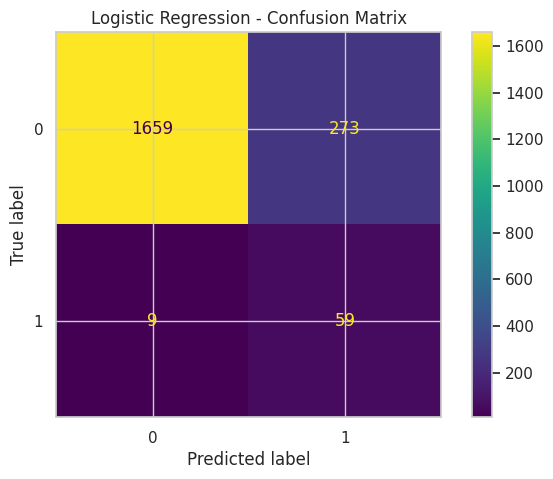

ROC AUC (LR): 0.9338920350748996


In [ ]:
log_reg = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    n_jobs=-1
)
log_reg.fit(X_train_scaled, y_train)

y_pred_lr = log_reg.predict(X_test_scaled)
y_prob_lr = log_reg.predict_proba(X_test_scaled)[:, 1]

print("Logistic Regression Report")
print(classification_report(y_test, y_pred_lr))

confusion_matrix_logistic_regression = confusion_matrix(y_test, y_pred_lr)
ConfusionMatrixDisplay(confusion_matrix_logistic_regression).plot()
plt.title("Logistic Regression Confusion Matrix")
plt.show()

roc_auc_lr = roc_auc_score(y_test, y_prob_lr)
print("ROC AUC (LR):", roc_auc_lr)


=== Random Forest Report ===
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1932
           1       0.95      0.78      0.85        68

    accuracy                           0.99      2000
   macro avg       0.97      0.89      0.93      2000
weighted avg       0.99      0.99      0.99      2000



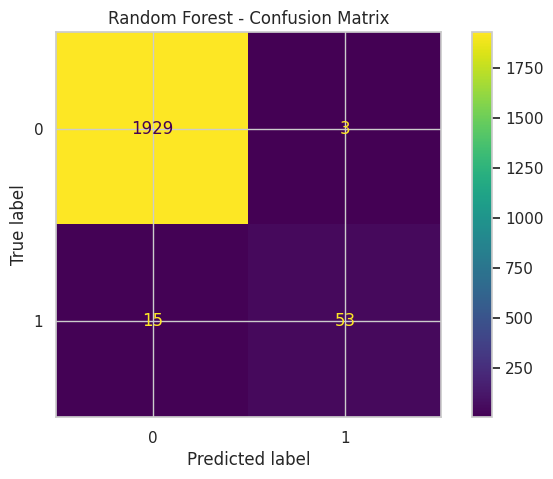

ROC AUC (RF): 0.9707594994519547


In [ ]:
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=2,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest Report")
print(classification_report(y_test, y_pred_rf))

confusion_matrix_random_forest = confusion_matrix(y_test, y_pred_rf)
ConfusionMatrixDisplay(confusion_matrix_random_forest).plot()
plt.title("Random Forest Confusion Matrix")
plt.show()

roc_auc_rf = roc_auc_score(y_test, y_prob_rf)
print("ROC AUC (RF):", roc_auc_rf)


=== XGBoost Report ===
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1932
           1       0.82      0.82      0.82        68

    accuracy                           0.99      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.99      0.99      0.99      2000



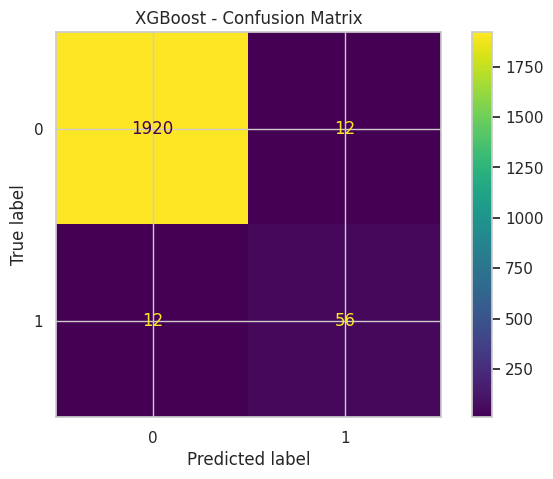

ROC AUC (XGB): 0.9784739982949702


In [ ]:
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    n_jobs=-1,
    random_state=42,
    scale_pos_weight= (y_train.value_counts()[0] / y_train.value_counts()[1])  # handle imbalance
)

xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

print("XGBoost Report")
print(classification_report(y_test, y_pred_xgb))

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
ConfusionMatrixDisplay(cm_xgb).plot()
plt.title("XGBoost Confusion Matrix")
plt.show()

roc_auc_xgb = roc_auc_score(y_test, y_prob_xgb)
print("ROC AUC (XGB):", roc_auc_xgb)


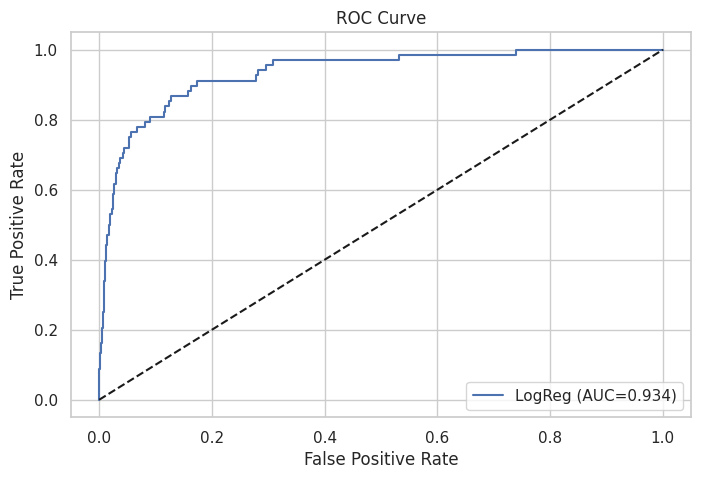

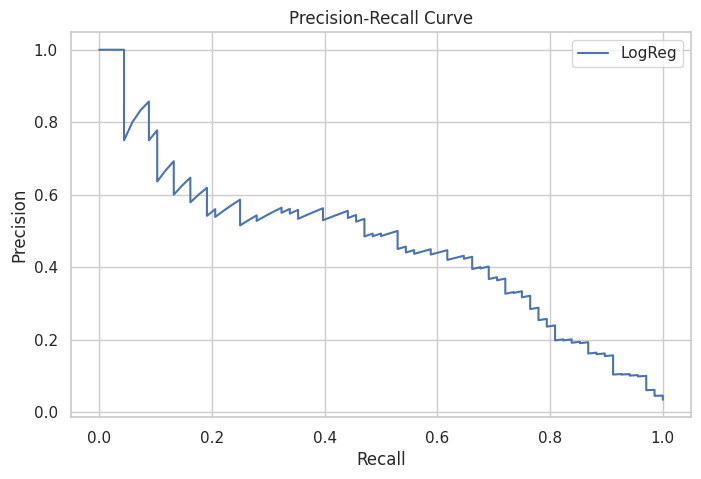

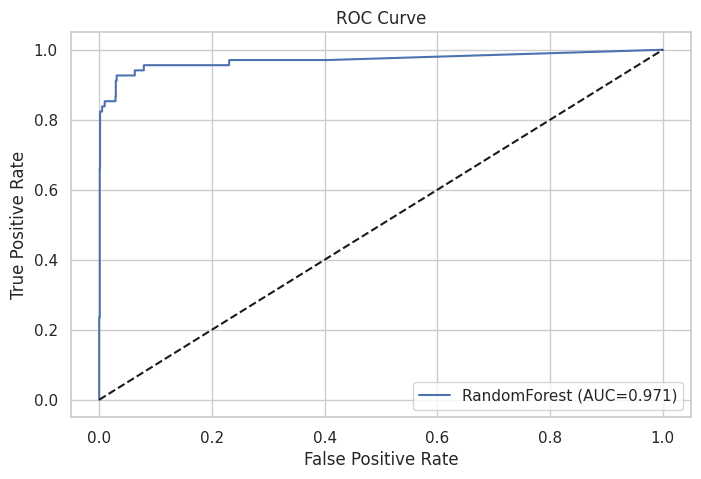

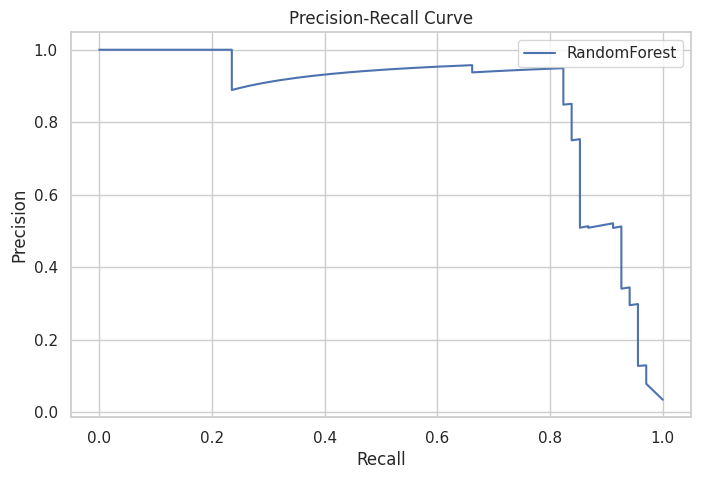

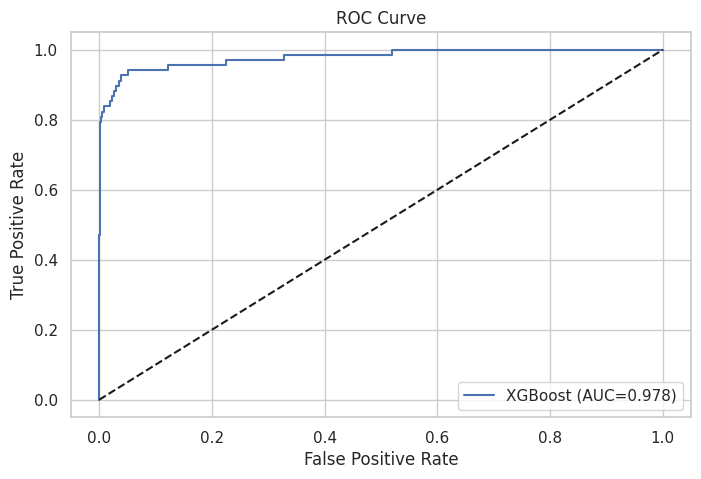

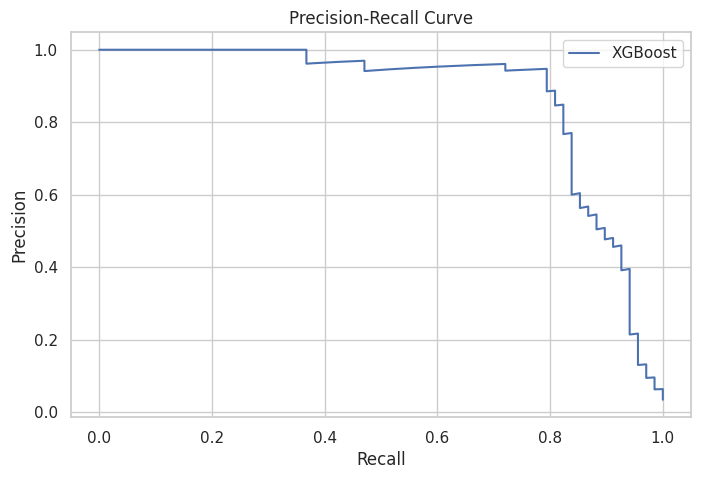

In [ ]:
def plot_roc_pr(y_true, y_prob, label):

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.plot(fpr, tpr, label=f"{label} (AUC={roc_auc_score(y_true, y_prob):.3f})")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()


    prec, rec, _ = precision_recall_curve(y_true, y_prob)
    plt.plot(rec, prec, label=label)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.show()

plot_roc_pr(y_test, y_prob_lr, "LogReg")
plot_roc_pr(y_test, y_prob_rf, "RandomForest")
plot_roc_pr(y_test, y_prob_xgb, "XGBoost")


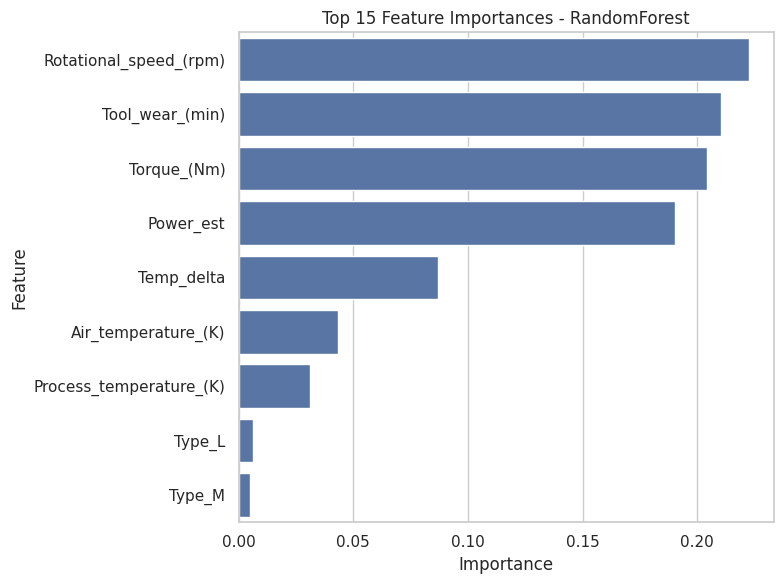

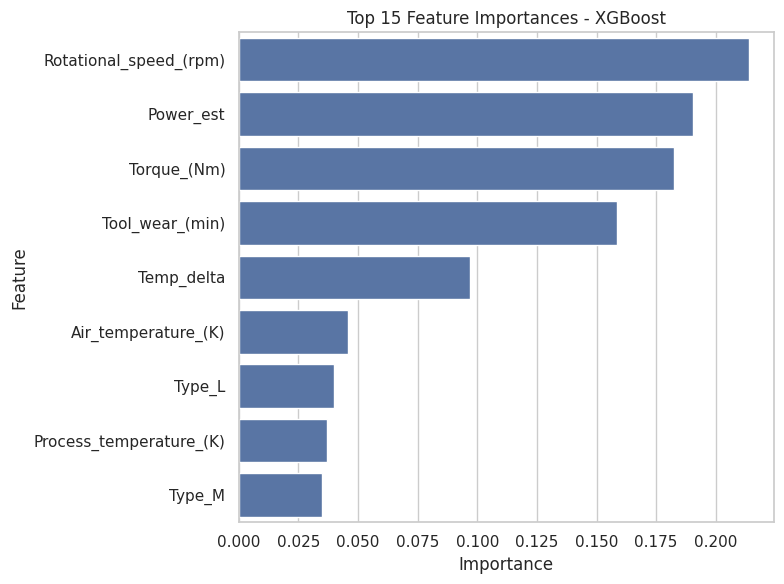

In [ ]:
rf_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=rf_importances[:15], y=rf_importances.index[:15])
plt.title("Top 15 Feature Importances - RandomForest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


xgb_importances = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=xgb_importances[:15], y=xgb_importances.index[:15])
plt.title("Top 15 Feature Importances - XGBoost")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [ ]:
def groq_maintenance_report(features: dict, model_name: str, prediction: int, prob: float):
    """
    Use Groq LLM to generate a short maintenance report
    from model output + sensor features.
    """
    prompt = f"""
    You are a senior predictive maintenance engineer.

    Machine snapshot (feature → value):
    {features}

    Model used: {model_name}
    Predicted failure risk label (1 = high risk, 0 = low risk): {prediction}
    Estimated failure probability: {prob:.2f}

    Write a concise report:
    - 1–2 sentences describing the machine condition
    - Mention which signals (e.g., torque, speed, temperature, tool wear) look abnormal
    - 2–3 clear maintenance recommendations
    - Use simple English, no tables, no markdown, under 120 words.
    """

    response = client.responses.create(
        model="openai/gpt-oss-20b",
        input=prompt,
    )

    return response.output_text


In [ ]:
def show_ai_report_for_sample(idx, model, model_name, X_test, y_test, y_prob):
    row = X_test.iloc[idx]
    true_label = y_test.iloc[idx]
    pred = model.predict([row])[0]
    prob = y_prob[idx]

    print(f"Sample #{idx}")
    print("True label (failure?):", true_label)
    print("Predicted label:", pred)
    print("Probability of failure:", prob)

    print("\n=== Groq AI Maintenance Report ===")
    print(groq_maintenance_report(row.to_dict(), model_name, int(pred), float(prob)))
    print("\n" + "="*60 + "\n")


for i in range(3):
    show_ai_report_for_sample(i, xgb, "XGBoost Predictive Maintenance Model", X_test, y_test, y_prob_xgb)


=== Sample #0 ===
True label (failure?): 0
Predicted label: 0
Probability of failure: 0.034833666

=== Groq AI Maintenance Report ===
The machine is operating with a low failure risk (3%) and appears generally healthy. However, the process temperature (309.8 K) and torque (62.7 Nm) are higher than typical for Type L, and tool wear (153 min) is nearing the end‑of‑life threshold.

Recommended actions:  
1) Schedule a preventive inspection and replace the tool before wear exceeds 160 min.  
2) Monitor and adjust the process temperature by improving cooling or recalibrating the heater.  
3) Verify motor speed stability and perform a balance check to keep rotational speed within spec.


=== Sample #1 ===
True label (failure?): 0
Predicted label: 0
Probability of failure: 0.00012841579

=== Groq AI Maintenance Report ===
The machine is operating normally with a predicted low risk of failure.  
The process temperature (312 K) and tool wear (135 min) are on the higher side, while the air tempe

In [ ]:
y_pred = y_pred_xgb
y_prob = y_prob_xgb

results_df = X_test.copy()
results_df["true"] = y_test.values
results_df["pred"] = y_pred
results_df["prob"] = y_prob

false_pos = results_df[(results_df["true"] == 0) & (results_df["pred"] == 1)]
false_neg = results_df[(results_df["true"] == 1) & (results_df["pred"] == 0)]

print("False Positives:", false_pos.shape[0])
print("False Negatives:", false_neg.shape[0])

false_pos.head()


False Positives: 12
False Negatives: 12


,Air_temperature_(K),Process_temperature_(K),Rotational_speed_(rpm),Torque_(Nm),Tool_wear_(min),Type_L,Type_M,Temp_delta,Power_est,true,pred,prob
4231,302.2,310.8,1340,47.8,54,True,False,8.6,64052.0,0,1,0.989288
1418,298.8,309.9,1320,47.4,210,True,False,11.1,62568.0,0,1,0.767852
8194,299.4,310.7,1426,45.7,213,True,False,11.3,65168.2,0,1,0.566069
5489,302.6,312.1,1499,35.0,215,True,False,9.5,52465.0,0,1,0.642895
3794,302.2,310.8,1356,48.3,36,False,True,8.6,65494.8,0,1,0.995305


In [ ]:
def groq_error_analysis(row, error_type="false_positive"):
    features = row.drop(["true", "pred", "prob"]).to_dict()
    true_label = int(row["true"])
    pred_label = int(row["pred"])
    prob = float(row["prob"])

    prompt = f"""
    You are a predictive maintenance expert.

    Machine features:
    {features}

    The model predicted failure label = {pred_label} with probability {prob:.2f},
    but the true label is {true_label}. This is a {error_type.replace("_", " ")}.

    1. Suggest why the model might have made this mistake based on the feature values.
    2. Suggest how we could improve the model or features to reduce such errors.
    Keep it under 120 words, simple English.
    """

    response = client.responses.create(
        model="openai/gpt-oss-20b",
        input=prompt,
    )
    return response.output_text


if not false_neg.empty:
    sample_fp = false_neg.iloc[0]
    print("=== Groq explanation for a false positive ===")
    print(groq_error_analysis(sample_fp, "false_positive"))


=== Groq explanation for a false positive ===
**Why the model missed the failure**

1. The machine’s temperatures and power are high (≈ 298 K, 309 K, 48 kW) and the tool is already worn (200 min).  
2. These values may still fall inside the “normal” range the model learned, especially if most training data had similar values but no failure.  
3. The model output 0 probability ≈ 0, suggesting it was very sure, perhaps because it never saw a failure in this feature region (class‑imbalance or missing warning signs).  

**How to improve**

1. Add more warning features (e.g., vibration, acoustic emission, time‑to‑failure of past cycles).  
2. Create lagged or rolling‑average features to capture trends before a failure.  
3. Re‑balance the training set or use cost‑sensitive learning to penalise missed failures.  
4. Lower the decision threshold or use a calibrated probability to trigger alerts sooner.


In [ ]:
import shap

shap.initjs()


In [ ]:
X_sample = X_test.sample(500, random_state=42)

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_sample)

print("SHAP values shape:", shap_values.shape)


SHAP values shape: (500, 9)


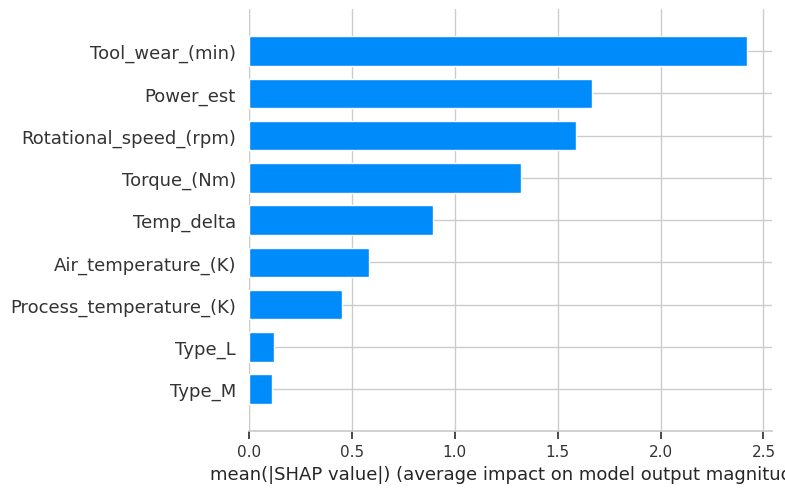

In [ ]:
shap.summary_plot(shap_values, X_sample, plot_type="bar")


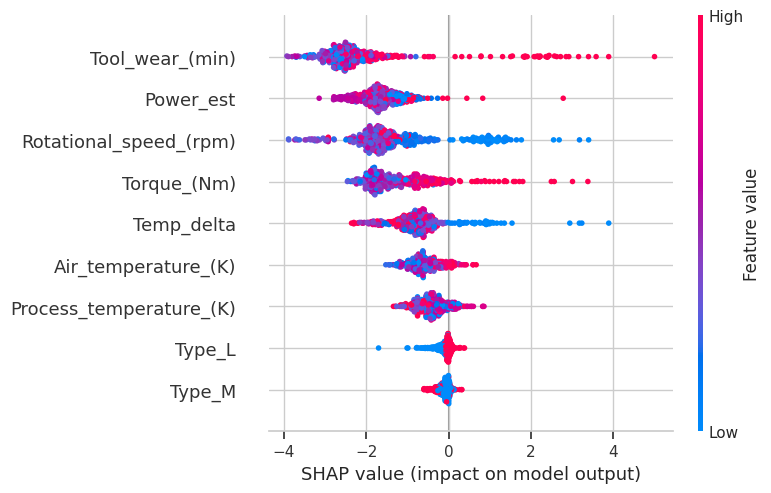

In [ ]:
shap.summary_plot(shap_values, X_sample)


In [ ]:
import joblib

joblib.dump(xgb, "xgb_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(X.columns.tolist(), "feature_names.pkl")

from google.colab import files
files.download("xgb_model.pkl")
files.download("scaler.pkl")
files.download("feature_names.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>